In [1]:
import random
import time
from typing import List

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
#from loguru import logger
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

try:
  from transformers import BertConfig, BertModel, BertTokenizer
except:
  !pip install transformers
  from transformers import BertConfig, BertModel, BertTokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_All = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/quora-question-pairs/train/train.csv')
df_All.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_train = df_All 

In [5]:
df_train_duplicate = df_train[df_train.is_duplicate == 1]
df_train_duplicate.reset_index(inplace = True)
df_train_duplicate.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [6]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of unique questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of unique questions in the training data: 537933
Number of questions that appear multiple times: 111780


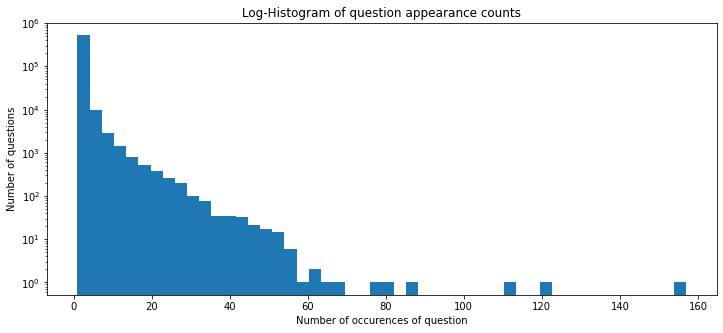

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

### Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

### we have a 37% positive class in this dataset.

# SIMCSE

In [8]:
import random
import time
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [9]:
def simcse_sup_loss(y_pred: 'tensor') -> 'tensor':
    """有监督的损失函数
    y_pred (tensor): bert的输出, [batch_size * 3, 768]
    
    """
    # 得到y_pred对应的label, 每第三句没有label, 跳过, label= [1, 0, 4, 3, ...]
    # torch.arrange(10) [0,1,2,3,4,5,6,7,8,9]
    y_true = torch.arange(y_pred.shape[0], device=DEVICE)
    
    '''
    tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
    tensor([ True,  True, False,  True,  True, False,  True,  True, False,  True])
    tensor([0, 1, 3, 4, 6, 7, 9])
    '''
    use_row = torch.where((y_true + 1) % 3 != 0)[0]
    
    '''
    torch.arange(10)
    tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    torch.arange(10) + 1
    tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
    (torch.arange(10) + 1) % 3 != 0
    tensor([ True,  True, False,  True,  True, False,  True,  True, False,  True])
    use_row  = torch.where((torch.arange(10) + 1) % 3 != 0)[0]
    tensor([0, 1, 3, 4, 6, 7, 9])
    use_row % 3
    tensor([0, 1, 0, 1, 0, 1, 0])
    (use_row - use_row % 3 * 2) 
    tensor([ 0, -1,  3,  2,  6,  5,  9])
    (use_row - use_row % 3 * 2) + 1
    tensor([ 1,  0,  4,  3,  7,  6, 10])
    意思是第0句话的postiive pair 是 1
    意思是第1句话的postiive pair 是 0
    意思是第4句话的postiive pair 是 3
    意思是第3句话的postiive pair 是 4
    '''
    
    y_true = (use_row - use_row % 3 * 2) + 1
    #y_true = (y_true - y_true % 2 * 2) + 1
    # batch内两两计算相似度, 得到相似度矩阵(对角矩阵)
    
    '''
    y_pred.unsqueeze(1)
    tensor([[ 1],
            [ 0],
            [ 4],
            [ 3],
            [ 7],
            [ 6],
            [10]])

    y_pred.unsqueeze(0)
    tensor([[ 1,  0,  4,  3,  7,  6, 10]])
    '''
    sim = F.cosine_similarity(y_pred.unsqueeze(1), y_pred.unsqueeze(0), dim=-1)
    # 将相似度矩阵对角线置为很小的值, 消除自身的影响
    
    '''
    pred.shape[0]
    7
    
    torch.eye(y_pred.shape[0], device=DEVICE)
    tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
    '''
    sim = sim - torch.eye(y_pred.shape[0], device=DEVICE) * 1e12
    # 选取有效的行
    '''
    应该是忽略掉第三个input，第三个是label
    '''
    sim = torch.index_select(sim, 0, use_row)
    # 相似度矩阵除以温度系数
    sim = sim / 0.05
    # 计算相似度矩阵与y_true的交叉熵损失
    loss = F.cross_entropy(sim, y_true)
    return torch.mean(loss)

In [10]:
def eval(model, dataloader) -> float:
    """模型评估函数 
    批量预测, 计算cos_sim, 转成numpy数组拼接起来, 一次性求spearman相关度
    """
    model.eval()
    sim_tensor = torch.tensor([], device=DEVICE)
    label_array = np.array([])
    output_array = []
    
    with torch.no_grad():
        for source, target, label in dataloader:
            # source        [batch, 1, seq_len] -> [batch, seq_len]
            source_input_ids = source['input_ids'].squeeze(1).to(DEVICE)
            source_attention_mask = source['attention_mask'].squeeze(1).to(DEVICE)
            source_token_type_ids = source['token_type_ids'].squeeze(1).to(DEVICE)
            source_pred = model(source_input_ids, source_attention_mask, source_token_type_ids)
            # target        [batch, 1, seq_len] -> [batch, seq_len]
            target_input_ids = target['input_ids'].squeeze(1).to(DEVICE)
            target_attention_mask = target['attention_mask'].squeeze(1).to(DEVICE)
            target_token_type_ids = target['token_type_ids'].squeeze(1).to(DEVICE)
            target_pred = model(target_input_ids, target_attention_mask, target_token_type_ids)
            # concat
            sim = F.cosine_similarity(source_pred, target_pred, dim=-1)
            sim_tensor = torch.cat((sim_tensor, sim), dim=0)
            label_array = np.append(label_array, np.array(label))  
            output_array.append(target_pred.cpu().detach().numpy())  
            
    # corrcoef       
    return spearmanr(label_array, sim_tensor.cpu().numpy()).correlation, sim_tensor, label_array, output_array

In [11]:
class SimcseModel(nn.Module):
    """Simcse有监督模型定义"""
    def __init__(self, pretrained_model: str, pooling: str):
        super(SimcseModel, self).__init__()
        # config = BertConfig.from_pretrained(pretrained_model)   # 有监督不需要修改dropout
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.pooling = pooling
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        
        # out = self.bert(input_ids, attention_mask, token_type_ids)
        out = self.bert(input_ids, attention_mask, token_type_ids, output_hidden_states=True)

        if self.pooling == 'cls':
            return out.last_hidden_state[:, 0]  # [batch, 768]
                  

# Read data

In [12]:
#creat a dictionary, each sentence has a unique idx
def question_dict(df):
    sen2idx = {}
    idx2sen = {}
    for i in range(len(df)):
        qid1 = df['qid1'][i] 
        qid2 = df['qid2'][i] 
        question1 = df['question1'][i] 
        question2 = df['question2'][i] 

        try:
            output_qid1 = sen2idx[question1]
            output_question1 = idx2sen[qid1]
        except:
            sen2idx[question1] = qid1
            idx2sen[qid1] = question1

        try:
            output_qid2 = sen2idx[question2]
            output_question2 = idx2sen[qid2]
        except:
            sen2idx[question2] = qid2
            idx2sen[qid2] = question2
        
    return sen2idx, idx2sen

sen2idx, idx2sen = question_dict(df_train)

In [13]:
def find_neighbors(df): 
    neighbors = {}

    for idx in tqdm(range(len(df))):
        qid1 = df['qid1'][idx] 
        qid2 = df['qid2'][idx] 

        try:
            values = neighbors[qid1]
            if qid2 not in values:
                values.append(qid2)
                neighbors[qid1] = values
        except:
             neighbors[qid1] = [qid2]


        try:
            values = neighbors[qid2]
            if qid1 not in values:
                values.append(qid1)
                neighbors[qid2] = values
        except:
             neighbors[qid2] = [qid1]
                
    return neighbors

In [14]:
def find_neighbors_neighbors(neighbors): 
    neighbors_neighbors = {}

    for q_idx in tqdm(neighbors.keys()):
        
        try:
            neighbors[q_idx]
        except:
            continue
            
        values_shallowcopy = neighbors[q_idx]
        values = values_shallowcopy[:]
        values_queue = values[:]

        #print(q_idx)
        #print(values)

        #print('while loop')

        while len(values_queue) > 0:

            for k in values_queue:
                #print(k)
                neighbor_values = neighbors[k]
                #print(neighbor_values)

                for j in neighbor_values:

                    if j not in values and j != q_idx:

                        values.append(j)
                        values_queue.append(j)

                #print(values)
                #print(values_queue)
                values_queue.pop(0)
                #print(values_queue)
                #print('********')


        neighbors_neighbors[q_idx] = values
        
    return neighbors_neighbors

In [15]:
def Check_length(neighbors_neighbors, L):  
    c = 0
    for k in neighbors_neighbors.keys():
        if len(neighbors_neighbors[k]) > L:
            c +=1
    
    print("number of sentence have more than %d neighbours" %L)
    print(c)

In [16]:
All_neighbors = find_neighbors(df_train)
All_neighbors_neighbors = find_neighbors_neighbors(All_neighbors)

Check_length(All_neighbors_neighbors, 1)
Check_length(All_neighbors_neighbors, 2)
Check_length(All_neighbors_neighbors, 3)
Check_length(All_neighbors_neighbors, 4)
Check_length(All_neighbors_neighbors, 5)

100%|██████████| 537933/537933 [18:10<00:00, 493.24it/s] 


number of sentence have more than 1 neighbours
224885
number of sentence have more than 2 neighbours
149597
number of sentence have more than 3 neighbours
107337
number of sentence have more than 4 neighbours
85902
number of sentence have more than 5 neighbours
73591


In [17]:
duplicate_neighbors = find_neighbors(df_train_duplicate)
duplicate_neighbors_neighbors = find_neighbors_neighbors(duplicate_neighbors)

Check_length(duplicate_neighbors_neighbors, 1)
Check_length(duplicate_neighbors_neighbors, 2)
Check_length(duplicate_neighbors_neighbors, 3)
Check_length(duplicate_neighbors_neighbors, 4)
Check_length(duplicate_neighbors_neighbors, 5)

100%|██████████| 149650/149650 [00:01<00:00, 79489.80it/s] 


number of sentence have more than 1 neighbours
53230
number of sentence have more than 2 neighbours
31369
number of sentence have more than 3 neighbours
21830
number of sentence have more than 4 neighbours
16859
number of sentence have more than 5 neighbours
13815


In [18]:
All_train_data = []

for i in tqdm(range(len(df_train_duplicate))):
    question1 = df_train_duplicate['question1'][i]
    question2 = df_train_duplicate['question2'][i]
    
    qid1 = df_train_duplicate['qid1'][i] 
    qid2 = df_train_duplicate['qid2'][i] 
    
    
    contradicts = list(set(duplicate_neighbors_neighbors[qid1]).symmetric_difference(set(All_neighbors_neighbors[qid1])))
    
    
    if len(contradicts) > 0:
        negative = random.choice(contradicts)
    else:
        All_neighbors_neighbors
        negative = random.choice([*All_neighbors_neighbors])
        
        while negative in duplicate_neighbors_neighbors[qid1]:
            #print('here')
            negative = random.choice([*All_neighbors_neighbors])
        
        #print('out')
    All_train_data.append((question1, question2, idx2sen[negative]))

100%|██████████| 149263/149263 [07:40<00:00, 324.39it/s]


### part of data

In [19]:
#length = int(len(All_train_data)/3)
#train_data = All_train_data[:length]
train_data = All_train_data
len(train_data)

149263

In [20]:
def read_file(path):
    
    df = pd.read_csv(path, header=None, warn_bad_lines = False, error_bad_lines = False)

    Data = []
    for i in range(len(df.index)):
        item = df.iloc[i][0].split('\t')
        Data.append([item[5],item[6],item[4]])
        
    return Data

In [21]:
def read_trainfile(path):
    
    df = pd.read_csv(path, header=None, warn_bad_lines = False, error_bad_lines = False)

    Data = []
    for i in range(len(df.index)):
        item = df.iloc[i][0].split('\t')
        if float(item[4]) > 4.0:
            Data.append([item[5],item[6],item[4]])
        
    return Data

In [22]:
eval_data = read_file('/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/dataset/STS/STSBenchmark/sts-dev.csv')
test_data = read_file('/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/dataset/STS/STSBenchmark/sts-test.csv')

## Dataloader

In [23]:
class TrainDataset(Dataset):
    """训练数据集, 重写__getitem__和__len__方法
    """
    def __init__(self, data: List):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def text_2_id(self, text: str):
        return tokenizer([text[0], text[1], text[2]], max_length=MAXLEN, 
                         truncation=True, padding='max_length', return_tensors='pt')
    
    def __getitem__(self, index: int):
        return self.text_2_id(self.data[index])

In [24]:
class TestDataset(Dataset):
    """测试数据集, 重写__getitem__和__len__方法
    """
    def __init__(self, data: List):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def text_2_id(self, text: str):
        return tokenizer(text, max_length=MAXLEN, truncation=True, 
                         padding='max_length', return_tensors='pt')
    
    def __getitem__(self, index):
        line = self.data[index]
        return self.text_2_id([line[0]]), self.text_2_id([line[1]]), float(line[2])

In [25]:
BATCH_SIZE = 64
MAXLEN = 64

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')    

train_dataloader = DataLoader(TrainDataset(train_data), batch_size=BATCH_SIZE)
dev_dataloader = DataLoader(TestDataset(eval_data), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(TestDataset(test_data), batch_size=BATCH_SIZE)

# train

In [26]:
EPOCHS = 1
LR = 1e-5
POOLING = 'cls'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
#DEVICE = 'cpu'

SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/saved_model/simcse_sup_neg.pt'


assert POOLING in ['cls', 'pooler', 'last-avg', 'first-last-avg']

In [27]:
# load model    
model_path = 'bert-base-uncased'

model = SimcseModel(pretrained_model = model_path, pooling = POOLING)
model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
model.train()
best = 0


for epoch in range(EPOCHS):
    
    
    for batch_idx, source in enumerate(tqdm(train_dataloader), start=1):
        
        # 维度转换 [batch, 2, seq_len] -> [batch * 2, sql_len]
        real_batch_num = source.get('input_ids').shape[0]
        input_ids = source.get('input_ids').view(real_batch_num * 3, -1).to(DEVICE)
        attention_mask = source.get('attention_mask').view(real_batch_num * 3, -1).to(DEVICE)
        token_type_ids = source.get('token_type_ids').view(real_batch_num * 3, -1).to(DEVICE)
        
        # 训练
        out = model(input_ids, attention_mask, token_type_ids)
        loss = simcse_sup_loss(out)
        
        torch.autograd.set_detect_anomaly(True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        # 评估
        if batch_idx % 10 == 0:
            print(f'loss: {loss.item():.4f}')
            corrcoef, sim_tensor, label_array, output_array = eval(model, dev_dataloader)
            model.train()
            if best < corrcoef:
                early_stop_batch = 0
                best = corrcoef
                torch.save(model.state_dict(), SAVE_PATH)
                print(f"higher corrcoef: {best:.4f} in batch: {batch_idx}, save model")
                continue

                
                
        torch.cuda.empty_cache()

  0%|          | 9/2333 [00:14<1:03:20,  1.64s/it]

loss: 1.3819


  0%|          | 10/2333 [00:22<2:12:27,  3.42s/it]

higher corrcoef: 0.4310 in batch: 10, save model


  1%|          | 19/2333 [00:37<1:07:01,  1.74s/it]

loss: 0.6706


  1%|          | 20/2333 [00:44<2:11:09,  3.40s/it]

higher corrcoef: 0.5687 in batch: 20, save model


  1%|          | 29/2333 [00:59<1:08:07,  1.77s/it]

loss: 0.4808


  1%|▏         | 30/2333 [01:07<2:11:02,  3.41s/it]

higher corrcoef: 0.6344 in batch: 30, save model


  2%|▏         | 39/2333 [01:21<1:06:25,  1.74s/it]

loss: 0.6232


  2%|▏         | 40/2333 [01:29<2:09:14,  3.38s/it]

higher corrcoef: 0.6726 in batch: 40, save model


  2%|▏         | 49/2333 [01:44<1:06:02,  1.74s/it]

loss: 0.5032


  2%|▏         | 50/2333 [01:51<2:08:48,  3.39s/it]

higher corrcoef: 0.7001 in batch: 50, save model


  3%|▎         | 59/2333 [02:06<1:05:56,  1.74s/it]

loss: 0.6224


  3%|▎         | 60/2333 [02:13<2:08:49,  3.40s/it]

higher corrcoef: 0.7184 in batch: 60, save model


  3%|▎         | 69/2333 [02:28<1:05:24,  1.73s/it]

loss: 0.3656


  3%|▎         | 70/2333 [02:35<2:07:37,  3.38s/it]

higher corrcoef: 0.7296 in batch: 70, save model


  3%|▎         | 79/2333 [02:50<1:04:56,  1.73s/it]

loss: 0.2976


  3%|▎         | 80/2333 [02:57<2:07:23,  3.39s/it]

higher corrcoef: 0.7358 in batch: 80, save model


  4%|▍         | 89/2333 [03:12<1:04:35,  1.73s/it]

loss: 0.5014


  4%|▍         | 90/2333 [03:19<2:06:45,  3.39s/it]

higher corrcoef: 0.7399 in batch: 90, save model


  4%|▍         | 99/2333 [03:34<1:04:32,  1.73s/it]

loss: 0.4090


  4%|▍         | 100/2333 [03:41<2:06:32,  3.40s/it]

higher corrcoef: 0.7464 in batch: 100, save model


  5%|▍         | 109/2333 [03:56<1:04:14,  1.73s/it]

loss: 0.4437


  5%|▍         | 110/2333 [04:04<2:05:17,  3.38s/it]

higher corrcoef: 0.7528 in batch: 110, save model


  5%|▌         | 119/2333 [04:18<1:03:50,  1.73s/it]

loss: 0.4086


  5%|▌         | 120/2333 [04:26<2:04:59,  3.39s/it]

higher corrcoef: 0.7567 in batch: 120, save model


  6%|▌         | 129/2333 [04:41<1:03:54,  1.74s/it]

loss: 0.4121


  6%|▌         | 130/2333 [04:48<2:04:50,  3.40s/it]

higher corrcoef: 0.7578 in batch: 130, save model


  6%|▌         | 139/2333 [05:03<1:03:17,  1.73s/it]

loss: 0.3400


  6%|▌         | 140/2333 [05:10<2:04:07,  3.40s/it]

higher corrcoef: 0.7598 in batch: 140, save model


  6%|▋         | 149/2333 [05:25<1:03:04,  1.73s/it]

loss: 0.3962


  6%|▋         | 150/2333 [05:32<2:03:30,  3.39s/it]

higher corrcoef: 0.7642 in batch: 150, save model


  7%|▋         | 159/2333 [05:47<1:02:35,  1.73s/it]

loss: 0.3138


  7%|▋         | 160/2333 [05:54<2:02:19,  3.38s/it]

higher corrcoef: 0.7658 in batch: 160, save model


  7%|▋         | 169/2333 [06:09<1:02:01,  1.72s/it]

loss: 0.5376


  7%|▋         | 170/2333 [06:16<2:01:40,  3.38s/it]

higher corrcoef: 0.7664 in batch: 170, save model


  8%|▊         | 179/2333 [06:31<1:02:09,  1.73s/it]

loss: 0.2640


  8%|▊         | 180/2333 [06:38<2:01:50,  3.40s/it]

higher corrcoef: 0.7689 in batch: 180, save model


  8%|▊         | 189/2333 [06:53<1:01:38,  1.72s/it]

loss: 0.3401


  8%|▊         | 190/2333 [07:01<2:00:52,  3.38s/it]

higher corrcoef: 0.7733 in batch: 190, save model


  9%|▊         | 199/2333 [07:15<1:01:37,  1.73s/it]

loss: 0.3635


  9%|▊         | 200/2333 [07:23<2:00:47,  3.40s/it]

higher corrcoef: 0.7763 in batch: 200, save model


  9%|▉         | 209/2333 [07:38<1:00:53,  1.72s/it]

loss: 0.3951


  9%|▉         | 210/2333 [07:46<2:12:36,  3.75s/it]

higher corrcoef: 0.7766 in batch: 210, save model


  9%|▉         | 219/2333 [08:01<1:01:23,  1.74s/it]

loss: 0.2606


  9%|▉         | 220/2333 [08:08<1:59:20,  3.39s/it]

higher corrcoef: 0.7786 in batch: 220, save model


 10%|▉         | 229/2333 [08:23<1:00:52,  1.74s/it]

loss: 0.4407


 10%|▉         | 230/2333 [08:30<1:59:02,  3.40s/it]

higher corrcoef: 0.7807 in batch: 230, save model


 10%|█         | 239/2333 [08:45<1:00:27,  1.73s/it]

loss: 0.2990


 10%|█         | 240/2333 [08:52<1:58:33,  3.40s/it]

higher corrcoef: 0.7824 in batch: 240, save model


 11%|█         | 249/2333 [09:07<59:59,  1.73s/it]  

loss: 0.2620


 11%|█         | 250/2333 [09:15<1:57:42,  3.39s/it]

higher corrcoef: 0.7831 in batch: 250, save model


 11%|█         | 259/2333 [09:29<59:48,  1.73s/it]  

loss: 0.4284


 11%|█         | 260/2333 [09:37<1:56:56,  3.38s/it]

higher corrcoef: 0.7839 in batch: 260, save model


 12%|█▏        | 269/2333 [09:52<59:32,  1.73s/it]  

loss: 0.2129


 12%|█▏        | 270/2333 [09:59<1:57:08,  3.41s/it]

higher corrcoef: 0.7841 in batch: 270, save model


 12%|█▏        | 279/2333 [10:14<59:12,  1.73s/it]  

loss: 0.1831


 12%|█▏        | 280/2333 [10:21<1:56:17,  3.40s/it]

higher corrcoef: 0.7863 in batch: 280, save model


 12%|█▏        | 289/2333 [10:36<58:57,  1.73s/it]

loss: 0.4500


 12%|█▏        | 290/2333 [10:43<1:55:05,  3.38s/it]

higher corrcoef: 0.7883 in batch: 290, save model


 13%|█▎        | 299/2333 [10:58<58:52,  1.74s/it]

loss: 0.3793


 13%|█▎        | 300/2333 [11:05<1:55:09,  3.40s/it]

higher corrcoef: 0.7910 in batch: 300, save model


 13%|█▎        | 309/2333 [11:20<58:36,  1.74s/it]

loss: 0.3136


 13%|█▎        | 310/2333 [11:27<1:54:44,  3.40s/it]

higher corrcoef: 0.7925 in batch: 310, save model


 14%|█▎        | 319/2333 [11:42<58:09,  1.73s/it]

loss: 0.3415


 14%|█▎        | 320/2333 [11:50<1:53:50,  3.39s/it]

higher corrcoef: 0.7926 in batch: 320, save model


 14%|█▍        | 329/2333 [12:05<58:04,  1.74s/it]

loss: 0.2517


 15%|█▍        | 339/2333 [12:25<56:21,  1.70s/it]

loss: 0.4229


 15%|█▍        | 349/2333 [12:46<56:00,  1.69s/it]

loss: 0.3344


 15%|█▌        | 359/2333 [13:07<55:42,  1.69s/it]

loss: 0.3793


 16%|█▌        | 369/2333 [13:28<55:33,  1.70s/it]

loss: 0.1526


 16%|█▌        | 379/2333 [13:49<55:16,  1.70s/it]

loss: 0.4762


 16%|█▋        | 380/2333 [13:56<1:49:32,  3.37s/it]

higher corrcoef: 0.7938 in batch: 380, save model


 17%|█▋        | 389/2333 [14:11<56:11,  1.73s/it]

loss: 0.1573


 17%|█▋        | 390/2333 [14:20<2:01:36,  3.76s/it]

higher corrcoef: 0.7967 in batch: 390, save model


 17%|█▋        | 399/2333 [14:34<56:27,  1.75s/it]

loss: 0.2158


 17%|█▋        | 400/2333 [14:42<1:49:24,  3.40s/it]

higher corrcoef: 0.7995 in batch: 400, save model


 18%|█▊        | 409/2333 [14:57<55:43,  1.74s/it]

loss: 0.3006


 18%|█▊        | 419/2333 [15:17<54:05,  1.70s/it]

loss: 0.1936


 18%|█▊        | 429/2333 [15:38<53:41,  1.69s/it]

loss: 0.1785


 19%|█▉        | 439/2333 [15:59<53:32,  1.70s/it]

loss: 0.1764


 19%|█▉        | 449/2333 [16:20<53:14,  1.70s/it]

loss: 0.1624


 20%|█▉        | 459/2333 [16:41<52:54,  1.69s/it]

loss: 0.2895


 20%|██        | 469/2333 [17:02<52:37,  1.69s/it]

loss: 0.3324


 21%|██        | 479/2333 [17:23<52:14,  1.69s/it]

loss: 0.3302


 21%|██        | 489/2333 [17:44<52:04,  1.69s/it]

loss: 0.3115


 21%|██        | 490/2333 [17:51<1:42:51,  3.35s/it]

higher corrcoef: 0.7998 in batch: 490, save model


 21%|██▏       | 499/2333 [18:06<52:56,  1.73s/it]

loss: 0.1946


 22%|██▏       | 509/2333 [18:27<51:31,  1.69s/it]

loss: 0.4616


 22%|██▏       | 510/2333 [18:34<1:41:52,  3.35s/it]

higher corrcoef: 0.8000 in batch: 510, save model


 22%|██▏       | 519/2333 [18:49<52:14,  1.73s/it]

loss: 0.3572


 23%|██▎       | 529/2333 [19:10<51:06,  1.70s/it]

loss: 0.4976


 23%|██▎       | 539/2333 [19:31<50:40,  1.69s/it]

loss: 0.1793


 24%|██▎       | 549/2333 [19:51<50:14,  1.69s/it]

loss: 0.4135


 24%|██▍       | 559/2333 [20:12<50:07,  1.70s/it]

loss: 0.2179


 24%|██▍       | 569/2333 [20:33<49:49,  1.69s/it]

loss: 0.2950


 25%|██▍       | 579/2333 [20:54<49:26,  1.69s/it]

loss: 0.2133


 25%|██▌       | 589/2333 [21:15<49:11,  1.69s/it]

loss: 0.1934


 26%|██▌       | 599/2333 [21:36<48:57,  1.69s/it]

loss: 0.1893


 26%|██▌       | 609/2333 [21:57<48:40,  1.69s/it]

loss: 0.2823


 27%|██▋       | 619/2333 [22:17<48:24,  1.69s/it]

loss: 0.3458


 27%|██▋       | 620/2333 [22:25<1:36:12,  3.37s/it]

higher corrcoef: 0.8010 in batch: 620, save model


 27%|██▋       | 629/2333 [22:40<48:38,  1.71s/it]

loss: 0.1991


 27%|██▋       | 639/2333 [23:01<49:01,  1.74s/it]

loss: 0.2077


 28%|██▊       | 649/2333 [23:22<47:34,  1.70s/it]

loss: 0.2967


 28%|██▊       | 659/2333 [23:43<47:18,  1.70s/it]

loss: 0.2733


 29%|██▊       | 669/2333 [24:04<46:53,  1.69s/it]

loss: 0.2722


 29%|██▊       | 670/2333 [24:11<1:33:52,  3.39s/it]

higher corrcoef: 0.8014 in batch: 670, save model


 29%|██▉       | 679/2333 [24:26<48:02,  1.74s/it]

loss: 0.3491


 29%|██▉       | 680/2333 [24:33<1:33:59,  3.41s/it]

higher corrcoef: 0.8033 in batch: 680, save model


 30%|██▉       | 689/2333 [24:48<47:39,  1.74s/it]

loss: 0.2984


 30%|██▉       | 690/2333 [24:55<1:32:55,  3.39s/it]

higher corrcoef: 0.8036 in batch: 690, save model


 30%|██▉       | 699/2333 [25:10<47:08,  1.73s/it]

loss: 0.2513


 30%|███       | 709/2333 [25:31<45:53,  1.70s/it]

loss: 0.1953


 31%|███       | 719/2333 [25:52<45:33,  1.69s/it]

loss: 0.2250


 31%|███       | 729/2333 [26:13<45:17,  1.69s/it]

loss: 0.2835


 32%|███▏      | 739/2333 [26:34<45:00,  1.69s/it]

loss: 0.4967


 32%|███▏      | 749/2333 [26:55<44:41,  1.69s/it]

loss: 0.2726


 33%|███▎      | 759/2333 [27:15<44:22,  1.69s/it]

loss: 0.3764


 33%|███▎      | 769/2333 [27:36<44:08,  1.69s/it]

loss: 0.2939


 33%|███▎      | 779/2333 [27:57<43:48,  1.69s/it]

loss: 0.2783


 33%|███▎      | 780/2333 [28:04<1:26:42,  3.35s/it]

higher corrcoef: 0.8037 in batch: 780, save model


 34%|███▍      | 789/2333 [28:19<44:43,  1.74s/it]

loss: 0.1363


 34%|███▍      | 790/2333 [28:26<1:27:16,  3.39s/it]

higher corrcoef: 0.8058 in batch: 790, save model


 34%|███▍      | 799/2333 [28:41<44:19,  1.73s/it]

loss: 0.2190


 34%|███▍      | 800/2333 [28:49<1:26:37,  3.39s/it]

higher corrcoef: 0.8067 in batch: 800, save model


 35%|███▍      | 809/2333 [29:03<43:58,  1.73s/it]

loss: 0.1914


 35%|███▌      | 819/2333 [29:24<42:47,  1.70s/it]

loss: 0.6242


 36%|███▌      | 829/2333 [29:45<42:35,  1.70s/it]

loss: 0.2129


 36%|███▌      | 839/2333 [30:06<42:10,  1.69s/it]

loss: 0.3527


 36%|███▋      | 849/2333 [30:27<41:53,  1.69s/it]

loss: 0.2840


 37%|███▋      | 859/2333 [30:48<41:37,  1.69s/it]

loss: 0.2214


 37%|███▋      | 869/2333 [31:09<41:21,  1.70s/it]

loss: 0.2908


 38%|███▊      | 879/2333 [31:30<41:03,  1.69s/it]

loss: 0.2626


 38%|███▊      | 889/2333 [31:51<40:49,  1.70s/it]

loss: 0.2485


 39%|███▊      | 899/2333 [32:11<40:33,  1.70s/it]

loss: 0.2456


 39%|███▉      | 909/2333 [32:32<40:11,  1.69s/it]

loss: 0.1797


 39%|███▉      | 919/2333 [32:53<39:51,  1.69s/it]

loss: 0.1952


 40%|███▉      | 929/2333 [33:14<39:38,  1.69s/it]

loss: 0.3584


 40%|████      | 939/2333 [33:35<39:20,  1.69s/it]

loss: 0.3267


 41%|████      | 949/2333 [33:56<39:02,  1.69s/it]

loss: 0.1536


 41%|████      | 959/2333 [34:17<38:44,  1.69s/it]

loss: 0.2058


 42%|████▏     | 969/2333 [34:38<38:36,  1.70s/it]

loss: 0.1706


 42%|████▏     | 970/2333 [34:45<1:16:58,  3.39s/it]

higher corrcoef: 0.8068 in batch: 970, save model


 42%|████▏     | 979/2333 [35:00<39:25,  1.75s/it]

loss: 0.1422


 42%|████▏     | 980/2333 [35:07<1:16:49,  3.41s/it]

higher corrcoef: 0.8111 in batch: 980, save model


 42%|████▏     | 989/2333 [35:22<38:57,  1.74s/it]

loss: 0.1896


 43%|████▎     | 999/2333 [35:43<37:42,  1.70s/it]

loss: 0.2383


 43%|████▎     | 1009/2333 [36:04<37:17,  1.69s/it]

loss: 0.2271


 44%|████▎     | 1019/2333 [36:25<37:04,  1.69s/it]

loss: 0.1294


 44%|████▍     | 1029/2333 [36:45<36:47,  1.69s/it]

loss: 0.2042


 45%|████▍     | 1039/2333 [37:06<36:27,  1.69s/it]

loss: 0.2896


 45%|████▍     | 1049/2333 [37:27<36:16,  1.69s/it]

loss: 0.2149


 45%|████▌     | 1059/2333 [37:48<35:56,  1.69s/it]

loss: 0.2021


 46%|████▌     | 1069/2333 [38:09<35:43,  1.70s/it]

loss: 0.3265


 46%|████▌     | 1079/2333 [38:30<35:23,  1.69s/it]

loss: 0.1873


 47%|████▋     | 1089/2333 [38:51<35:10,  1.70s/it]

loss: 0.1841


 47%|████▋     | 1099/2333 [39:12<34:53,  1.70s/it]

loss: 0.3311


 48%|████▊     | 1109/2333 [39:32<34:35,  1.70s/it]

loss: 0.2124


 48%|████▊     | 1119/2333 [39:53<34:18,  1.70s/it]

loss: 0.2466


 48%|████▊     | 1129/2333 [40:14<34:00,  1.69s/it]

loss: 0.1524


 49%|████▉     | 1139/2333 [40:35<33:42,  1.69s/it]

loss: 0.3024


 49%|████▉     | 1149/2333 [40:56<33:23,  1.69s/it]

loss: 0.2256


 49%|████▉     | 1150/2333 [41:03<1:06:11,  3.36s/it]

higher corrcoef: 0.8116 in batch: 1150, save model


 50%|████▉     | 1159/2333 [41:18<33:51,  1.73s/it]

loss: 0.2385


 50%|████▉     | 1160/2333 [41:25<1:06:31,  3.40s/it]

higher corrcoef: 0.8120 in batch: 1160, save model


 50%|█████     | 1169/2333 [41:40<33:21,  1.72s/it]

loss: 0.2744


 51%|█████     | 1179/2333 [42:01<32:38,  1.70s/it]

loss: 0.2054


 51%|█████     | 1189/2333 [42:22<32:21,  1.70s/it]

loss: 0.2192


 51%|█████▏    | 1199/2333 [42:43<31:58,  1.69s/it]

loss: 0.3398


 52%|█████▏    | 1209/2333 [43:04<31:42,  1.69s/it]

loss: 0.1726


 52%|█████▏    | 1219/2333 [43:25<31:26,  1.69s/it]

loss: 0.1609


 53%|█████▎    | 1229/2333 [43:46<31:11,  1.70s/it]

loss: 0.1535


 53%|█████▎    | 1239/2333 [44:06<30:47,  1.69s/it]

loss: 0.1648


 54%|█████▎    | 1249/2333 [44:27<30:37,  1.69s/it]

loss: 0.2640


 54%|█████▍    | 1259/2333 [44:48<30:15,  1.69s/it]

loss: 0.2483


 54%|█████▍    | 1269/2333 [45:09<30:05,  1.70s/it]

loss: 0.1513


 55%|█████▍    | 1279/2333 [45:31<30:07,  1.72s/it]

loss: 0.1976


 55%|█████▌    | 1289/2333 [45:51<29:26,  1.69s/it]

loss: 0.3337


 56%|█████▌    | 1299/2333 [46:12<29:14,  1.70s/it]

loss: 0.2314


 56%|█████▌    | 1309/2333 [46:33<28:54,  1.69s/it]

loss: 0.2649


 57%|█████▋    | 1319/2333 [46:54<28:35,  1.69s/it]

loss: 0.1419


 57%|█████▋    | 1329/2333 [47:15<28:21,  1.69s/it]

loss: 0.1766


 57%|█████▋    | 1339/2333 [47:36<27:59,  1.69s/it]

loss: 0.0951


 58%|█████▊    | 1349/2333 [47:57<27:46,  1.69s/it]

loss: 0.2084


 58%|█████▊    | 1359/2333 [48:17<27:28,  1.69s/it]

loss: 0.2314


 59%|█████▊    | 1369/2333 [48:38<27:09,  1.69s/it]

loss: 0.2619


 59%|█████▉    | 1379/2333 [48:59<26:57,  1.70s/it]

loss: 0.2966


 60%|█████▉    | 1389/2333 [49:20<26:37,  1.69s/it]

loss: 0.2401


 60%|█████▉    | 1399/2333 [49:41<26:21,  1.69s/it]

loss: 0.2722


 60%|██████    | 1409/2333 [50:02<26:04,  1.69s/it]

loss: 0.2456


 61%|██████    | 1419/2333 [50:23<25:48,  1.69s/it]

loss: 0.2436


 61%|██████▏   | 1429/2333 [50:43<25:30,  1.69s/it]

loss: 0.2245


 62%|██████▏   | 1439/2333 [51:04<25:11,  1.69s/it]

loss: 0.1341


 62%|██████▏   | 1449/2333 [51:25<24:56,  1.69s/it]

loss: 0.1527


 63%|██████▎   | 1459/2333 [51:46<24:40,  1.69s/it]

loss: 0.1564


 63%|██████▎   | 1469/2333 [52:07<24:22,  1.69s/it]

loss: 0.1945


 63%|██████▎   | 1479/2333 [52:28<24:08,  1.70s/it]

loss: 0.1934


 64%|██████▍   | 1489/2333 [52:49<23:51,  1.70s/it]

loss: 0.1676


 64%|██████▍   | 1499/2333 [53:10<23:32,  1.69s/it]

loss: 0.1951


 65%|██████▍   | 1509/2333 [53:30<23:12,  1.69s/it]

loss: 0.1175


 65%|██████▌   | 1519/2333 [53:51<22:59,  1.69s/it]

loss: 0.1844


 66%|██████▌   | 1529/2333 [54:12<22:40,  1.69s/it]

loss: 0.1743


 66%|██████▌   | 1539/2333 [54:33<22:21,  1.69s/it]

loss: 0.1331


 66%|██████▋   | 1549/2333 [54:54<22:10,  1.70s/it]

loss: 0.3370


 67%|██████▋   | 1559/2333 [55:15<21:49,  1.69s/it]

loss: 0.1523


 67%|██████▋   | 1569/2333 [55:36<21:33,  1.69s/it]

loss: 0.1412


 68%|██████▊   | 1579/2333 [55:57<21:16,  1.69s/it]

loss: 0.2043


 68%|██████▊   | 1580/2333 [56:05<46:21,  3.69s/it]

higher corrcoef: 0.8137 in batch: 1580, save model


 68%|██████▊   | 1589/2333 [56:20<21:41,  1.75s/it]

loss: 0.4235


 68%|██████▊   | 1590/2333 [56:27<41:59,  3.39s/it]

higher corrcoef: 0.8152 in batch: 1590, save model


 69%|██████▊   | 1599/2333 [56:42<21:12,  1.73s/it]

loss: 0.1337


 69%|██████▊   | 1600/2333 [56:49<41:22,  3.39s/it]

higher corrcoef: 0.8165 in batch: 1600, save model


 69%|██████▉   | 1609/2333 [57:04<20:53,  1.73s/it]

loss: 0.1306


 69%|██████▉   | 1619/2333 [57:25<20:07,  1.69s/it]

loss: 0.2567


 70%|██████▉   | 1629/2333 [57:46<19:53,  1.69s/it]

loss: 0.1744


 70%|███████   | 1639/2333 [58:07<19:35,  1.69s/it]

loss: 0.2895


 71%|███████   | 1649/2333 [58:28<19:17,  1.69s/it]

loss: 0.2134


 71%|███████   | 1659/2333 [58:48<18:59,  1.69s/it]

loss: 0.1617


 72%|███████▏  | 1669/2333 [59:09<18:41,  1.69s/it]

loss: 0.2175


 72%|███████▏  | 1679/2333 [59:30<18:29,  1.70s/it]

loss: 0.2339


 72%|███████▏  | 1689/2333 [59:51<18:11,  1.69s/it]

loss: 0.3292


 73%|███████▎  | 1699/2333 [1:00:12<17:52,  1.69s/it]

loss: 0.1943


 73%|███████▎  | 1709/2333 [1:00:33<17:38,  1.70s/it]

loss: 0.3294


 74%|███████▎  | 1719/2333 [1:00:54<17:19,  1.69s/it]

loss: 0.1923


 74%|███████▍  | 1729/2333 [1:01:14<17:01,  1.69s/it]

loss: 0.3924


 75%|███████▍  | 1739/2333 [1:01:35<16:47,  1.70s/it]

loss: 0.3033


 75%|███████▍  | 1749/2333 [1:01:56<16:29,  1.69s/it]

loss: 0.2703


 75%|███████▌  | 1759/2333 [1:02:17<16:11,  1.69s/it]

loss: 0.1107


 76%|███████▌  | 1769/2333 [1:02:38<15:54,  1.69s/it]

loss: 0.3008


 76%|███████▋  | 1779/2333 [1:02:59<15:36,  1.69s/it]

loss: 0.1561


 77%|███████▋  | 1789/2333 [1:03:20<15:20,  1.69s/it]

loss: 0.1522


 77%|███████▋  | 1799/2333 [1:03:40<15:03,  1.69s/it]

loss: 0.1694


 77%|███████▋  | 1800/2333 [1:03:48<29:48,  3.35s/it]

higher corrcoef: 0.8179 in batch: 1800, save model


 78%|███████▊  | 1809/2333 [1:04:03<15:09,  1.73s/it]

loss: 0.2760


 78%|███████▊  | 1819/2333 [1:04:23<14:30,  1.69s/it]

loss: 0.1144


 78%|███████▊  | 1829/2333 [1:04:44<14:13,  1.69s/it]

loss: 0.2396


 79%|███████▉  | 1839/2333 [1:05:05<13:56,  1.69s/it]

loss: 0.2460


 79%|███████▉  | 1849/2333 [1:05:26<13:38,  1.69s/it]

loss: 0.1092


 80%|███████▉  | 1859/2333 [1:05:47<13:21,  1.69s/it]

loss: 0.2715


 80%|████████  | 1869/2333 [1:06:08<13:03,  1.69s/it]

loss: 0.2992


 81%|████████  | 1879/2333 [1:06:29<12:48,  1.69s/it]

loss: 0.1558


 81%|████████  | 1889/2333 [1:06:49<12:31,  1.69s/it]

loss: 0.3594


 81%|████████▏ | 1899/2333 [1:07:10<12:15,  1.70s/it]

loss: 0.2218


 82%|████████▏ | 1909/2333 [1:07:32<12:01,  1.70s/it]

loss: 0.2217


 82%|████████▏ | 1919/2333 [1:07:53<11:41,  1.69s/it]

loss: 0.1763


 83%|████████▎ | 1929/2333 [1:08:13<11:23,  1.69s/it]

loss: 0.3026


 83%|████████▎ | 1939/2333 [1:08:34<11:07,  1.70s/it]

loss: 0.1718


 84%|████████▎ | 1949/2333 [1:08:55<10:48,  1.69s/it]

loss: 0.1741


 84%|████████▍ | 1959/2333 [1:09:16<10:31,  1.69s/it]

loss: 0.2759


 84%|████████▍ | 1969/2333 [1:09:37<10:17,  1.70s/it]

loss: 0.3089


 85%|████████▍ | 1979/2333 [1:09:58<09:59,  1.69s/it]

loss: 0.2951


 85%|████████▌ | 1989/2333 [1:10:19<09:43,  1.70s/it]

loss: 0.2151


 86%|████████▌ | 1999/2333 [1:10:40<09:25,  1.69s/it]

loss: 0.1224


 86%|████████▌ | 2009/2333 [1:11:00<09:08,  1.69s/it]

loss: 0.1157


 87%|████████▋ | 2019/2333 [1:11:21<08:51,  1.69s/it]

loss: 0.1929


 87%|████████▋ | 2029/2333 [1:11:42<08:34,  1.69s/it]

loss: 0.1936


 87%|████████▋ | 2039/2333 [1:12:03<08:18,  1.70s/it]

loss: 0.1255


 88%|████████▊ | 2049/2333 [1:12:24<08:00,  1.69s/it]

loss: 0.2447


 88%|████████▊ | 2059/2333 [1:12:45<07:44,  1.69s/it]

loss: 0.3929


 88%|████████▊ | 2060/2333 [1:12:52<15:15,  3.35s/it]

higher corrcoef: 0.8189 in batch: 2060, save model


 89%|████████▊ | 2069/2333 [1:13:07<07:37,  1.73s/it]

loss: 0.1579


 89%|████████▉ | 2079/2333 [1:13:28<07:10,  1.69s/it]

loss: 0.3140


 90%|████████▉ | 2089/2333 [1:13:49<06:51,  1.69s/it]

loss: 0.1362


 90%|████████▉ | 2099/2333 [1:14:09<06:36,  1.69s/it]

loss: 0.3243


 90%|█████████ | 2109/2333 [1:14:30<06:18,  1.69s/it]

loss: 0.2369


 91%|█████████ | 2119/2333 [1:14:51<06:01,  1.69s/it]

loss: 0.2186


 91%|█████████▏| 2129/2333 [1:15:12<05:45,  1.69s/it]

loss: 0.1876


 92%|█████████▏| 2139/2333 [1:15:33<05:28,  1.69s/it]

loss: 0.1462


 92%|█████████▏| 2149/2333 [1:15:54<05:10,  1.69s/it]

loss: 0.1364


 93%|█████████▎| 2159/2333 [1:16:14<04:54,  1.70s/it]

loss: 0.1833


 93%|█████████▎| 2169/2333 [1:16:35<04:37,  1.69s/it]

loss: 0.2113


 93%|█████████▎| 2179/2333 [1:16:56<04:20,  1.69s/it]

loss: 0.1550


 94%|█████████▍| 2189/2333 [1:17:17<04:03,  1.69s/it]

loss: 0.1916


 94%|█████████▍| 2199/2333 [1:17:38<03:46,  1.69s/it]

loss: 0.1109


 95%|█████████▍| 2209/2333 [1:17:59<03:30,  1.70s/it]

loss: 0.1308


 95%|█████████▍| 2210/2333 [1:18:06<06:54,  3.37s/it]

higher corrcoef: 0.8202 in batch: 2210, save model


 95%|█████████▌| 2219/2333 [1:18:21<03:17,  1.73s/it]

loss: 0.2679


 96%|█████████▌| 2229/2333 [1:18:42<02:56,  1.69s/it]

loss: 0.2239


 96%|█████████▌| 2239/2333 [1:19:03<02:38,  1.69s/it]

loss: 0.0835


 96%|█████████▋| 2249/2333 [1:19:23<02:22,  1.69s/it]

loss: 0.1492


 97%|█████████▋| 2259/2333 [1:19:44<02:05,  1.69s/it]

loss: 0.1780


 97%|█████████▋| 2269/2333 [1:20:05<01:48,  1.69s/it]

loss: 0.1389


 98%|█████████▊| 2279/2333 [1:20:26<01:31,  1.70s/it]

loss: 0.2193


 98%|█████████▊| 2289/2333 [1:20:47<01:14,  1.70s/it]

loss: 0.2438


 99%|█████████▊| 2299/2333 [1:21:08<00:57,  1.69s/it]

loss: 0.1521


 99%|█████████▉| 2309/2333 [1:21:29<00:40,  1.69s/it]

loss: 0.2737


 99%|█████████▉| 2319/2333 [1:21:50<00:23,  1.69s/it]

loss: 0.0829


100%|█████████▉| 2329/2333 [1:22:10<00:06,  1.70s/it]

loss: 0.0724


100%|██████████| 2333/2333 [1:22:20<00:00,  2.12s/it]


In [29]:
model.load_state_dict(torch.load(SAVE_PATH))
dev_corrcoef, dev_sim_tensor, dev_label_array, output_array = eval(model, dev_dataloader)
test_corrcoef, test_sim_tensor, test_label_array, output_array = eval(model, test_dataloader)
print(f'dev_corrcoef: {dev_corrcoef:.4f}')
print(f'test_corrcoef: {test_corrcoef:.4f}')

dev_corrcoef: 0.8202
test_corrcoef: 0.7938


In [30]:
torch.cuda.empty_cache()